# ARIMA, ETS, and GARCH - Time Series Prediction

## Objective of this Notebook
- Show how to apply [R](https://www.r-project.org/) and the [mlr](https://mlr-org.github.io/) package for rolling forecast
- Hyper-parameter optimization for the GARCH model with R package [mlrMBO](https://mlr-org.github.io/mlrMBO/)

In [68]:
# ignore warnings in this demo notebook
import warnings; warnings.simplefilter('ignore')

# enables the %%R magic
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [69]:
%%R
library(tidyverse)
theme_set(theme_bw(base_size = 20))

## Task Description

### Load Data

You may have to modify the data preparation file (*00_load_smart_meter_data.R*) when applying this code to your own data. In this example, we just have a look at one series, namely the series with id **MAC000002**. We have:

- Number of series: 1
- Date range: 2013-10-30 00:00:00 CET to 2014-02-27 23:00:00 CET (121 days)

In [70]:
%%R 
library(mlr)
library(tidyverse)
data_path = "https://raw.githubusercontent.com/anofox/m3_konferenz/master/prepared_data/london_smart_meter/"
file = 'smart_meters_london_cleaned_same_start_with_weather_example.csv'
df <- read_csv(file.path(data_path, file))
df$date_time <- df$date_time + 3600
startDate <- as.POSIXct('2013-12-31 00:00:00')
df %>% 
  filter(date_time > startDate) -> df
glimpse(df)

Observations: 1,416
Variables: 11
$ visibility          <dbl> 11.46, 11.41, 11.57, 11.96, 12.26, 12.30, 12.34...
$ windBearing         <int> 170, 162, 161, 161, 161, 164, 154, 162, 178, 18...
$ temperature         <dbl> 6.82, 6.92, 7.50, 8.11, 8.72, 9.13, 9.08, 8.68,...
$ date_time           <dttm> 2013-12-31 00:00:00, 2013-12-31 01:00:00, 2013...
$ dewPoint            <dbl> 4.94, 5.43, 6.02, 6.31, 7.08, 6.80, 6.68, 7.21,...
$ pressure            <dbl> 1012.35, 1011.76, 1010.82, 1009.59, 1008.74, 10...
$ apparentTemperature <dbl> 4.62, 4.62, 5.19, 5.92, 6.14, 6.33, 6.24, 5.53,...
$ windSpeed           <dbl> 3.10, 3.29, 3.52, 3.53, 4.63, 5.44, 5.54, 6.11,...
$ humidity            <dbl> 0.88, 0.90, 0.90, 0.88, 0.89, 0.85, 0.85, 0.90,...
$ id                  <chr> "MAC000002", "MAC000002", "MAC000002", "MAC0000...
$ energy              <dbl> 0.888, 0.894, 0.312, 0.219, 0.218, 0.208, 0.201...


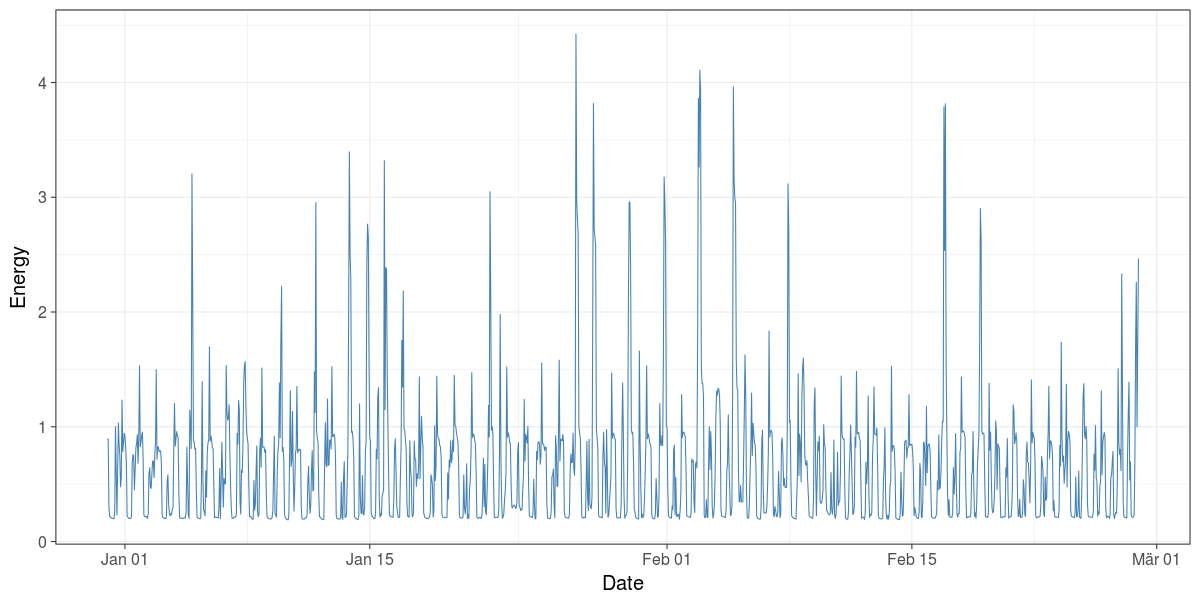

In [71]:
%%R -w 1200 -h 600
ggplot(df) +
    geom_line(aes(x = date_time, y = energy), color = "steelblue") +
    xlab("Date") + ylab("Energy")

## ARIMA, ETS, and GARCH

### Parameters

Similar to the others experiments, we perform a one day ahead forecast. All hard work in this notebook is done by the [mlr](https://mlr-org.github.io/) (Machine Learning for R) R package and its branch for time series ([Vignette](https://rawgit.com/Stevo15025/mlrForcastingTutorial/gh-pages/forcasting_in_mlr.html)).

In [72]:
%%R 
# Parameters
nOut <- 24
# we have to use a relative value for setting the (initial) training window
initWindow <- 28 * 24 / nrow(df)

### Rolling Forecast

For performing a rolling forecast with **mlr**, we have to setup

1. A **forecast regression task**, where the target and date column are defined.
2. Create a **resample description**. There are two options for time series:
        a. FixedCV: fixed train window
        b. GrowingCV: growing train window
3. Define a **learner**, e.g. ARIMA

Finally, the resampling is performed.


#### Forecast Regression Task
Internally, the *data.frame* is transformed to a `ts` object. Therefore, the function `makeForecastRegrTask` needs the date column.  

In [73]:
%%R
df %>% 
  select(date_time, energy) %>% 
  as.data.frame() %>% 
  makeForecastRegrTask(id        = "smart_meter_london", 
                       data      = ., 
                       target    = "energy", 
                       frequency = 24L, 
                       date.col  = "date_time") -> fcregr.task
fcregr.task

Task: smart_meter_london
Type: fcregr
Target: energy
Observations: 1416
Dates:
 Start: 2013-12-31 
 End:   2014-02-27 23:00:00
Frequency: 24
Features:
   numerics     factors     ordered functionals 
          0           0           0           0 
Missings: FALSE
Has weights: FALSE
Has blocking: FALSE


#### Resample Description
This object describes which 
- resampling method is used (**FixedCV**)
- the forecast horizon, and
- the size of the initial window (and consecutive windows when `FixedCV` is chosen)

In [74]:
%%R
resamp.desc <- makeResampleDesc("FixedCV", horizon = nOut, initial.window = initWindow, skip = nOut)
resamp.desc

Window description:
 Fixed: 47.46 % in initial window, horizon of 24, and skipping 24 windows.
Predict: test
Stratification: FALSE


#### Define Learners

In the firest step, we test naivly 
- Auto Regressive Integrated Moving Average (ARIMA) and 
- Exponential Smoothing State Space Model (ETS)

for forecasting

In [75]:
%%R 
arima.model <- makeLearner("fcregr.Arima")
ets.model <- makeLearner("fcregr.ets") 
arima.model

Learner fcregr.Arima from package forecast
Type: fcregr
Name: AutoRegressive Integrated Moving Average; Short name: Arima
Class: fcregr.Arima
Properties: numerics,quantile
Predict-Type: response
Hyperparameters: 



In [76]:
%%R 
ets.model

Learner fcregr.ets from package forecast
Type: fcregr
Name: Exponential smoothing state space model; Short name: ets
Class: fcregr.ets
Properties: numerics,quantile
Predict-Type: response
Hyperparameters: 



## Rolling Forecast

Now, we are abel to get the resample resutls. We use [rmse](https://en.wikipedia.org/wiki/Root-mean-square_deviation) and [mape](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) for evaluating the rolling forecast for both models.

### AutoRegressive Integrated Moving Average

An **ARIMA** is a generalization of an **ARMA** (autoregressive moving average) model. Given a real valued time series $X_t$ with discrete index $t$, an **ARMA(p, q)** model is then given by

$$
X_t - \alpha_1 X_{t-1} - \cdots - \alpha_{p} X_{t-p} = \varepsilon_t + \theta_{1}\varepsilon_{t - 1} + \cdots + \theta_{q}\varepsilon_{t - q},
$$
where the $\alpha_i$ are the coefficients of the **autoregressive** part, the $\theta_i$ coefficients of the **moving average** part, and the $\varepsilon_i$ are the i.i.d. **error terms**.

Assume that the autoregressive part has a unit root of multiplicity $d$, then the **ARIMA(p', d, q)**
 with p' = p - d is defined as
 
 $$
 \left(1 - \sum\limits_{i=1}^{p'} \phi_i \Delta^i\right)(1 - \Delta)^dX_t =  \left(1 - \sum\limits_{i=1}^{q}\theta_i\Delta^i \right) \varepsilon_t
 $$

In [77]:
%%R
# ARIMA
arima.resample <- resample(learner    = arima.model, 
                           task       = fcregr.task, 
                           resampling = resamp.desc, 
                           measures   = list(mape, rmse))

In [78]:
%%R
arima.resample

Resample Result
Task: smart_meter_london
Learner: fcregr.Arima
Aggr perf: mape.test.mean=1.0356565,rmse.test.rmse=0.5906524
Runtime: 0.434104


The ARIMA model delivers a quite bad result. Let's have a look at the forecast

In [79]:
%%R
predictions <- arima.resample$pred$data
glimpse(predictions)

Observations: 744
Variables: 5
$ id       <int> 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684...
$ truth    <dbl> 0.901, 0.811, 0.231, 0.216, 0.213, 0.212, 0.209, 0.206, 0....
$ response <dbl> 0.6450342, 0.6450342, 0.6450342, 0.6450342, 0.6450342, 0.6...
$ iter     <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...
$ set      <fct> test, test, test, test, test, test, test, test, test, test...


In [80]:
%%R
library(data.table)
add_time <- function(df, predictions) {
    df %>%
    mutate(id = 1:nrow(df)) %>%
    select(id, date_time) -> df_time
    predictions %>%
        left_join(df_time, by = "id") %>%
        select(date_time, truth, response) %>%
        melt(id.var = "date_time", variable.name = "Method") -> predictionsLong
}

plot_predictions <- function(predictions) {
    ggplot(predictionsLong) +
        geom_line(aes(x = date_time, y = value, group = Method, color = Method)) +
        scale_color_manual(values = c("steelblue", "red3")) + 
        xlab("Date") + ylab("Energy") +
        theme(legend.position = "top")
}

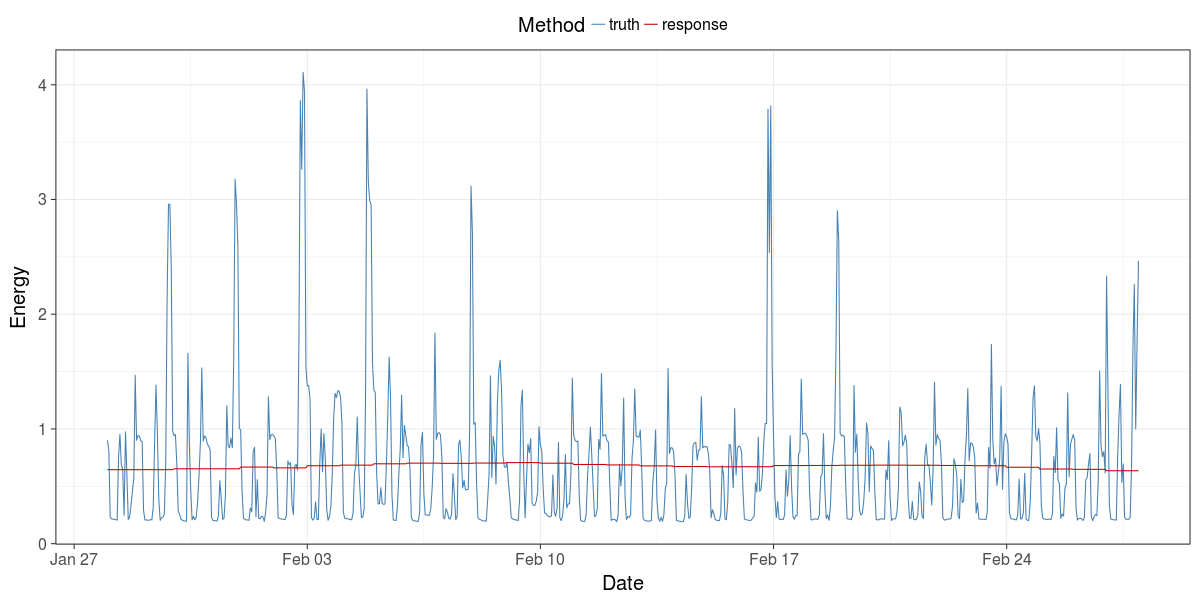

In [81]:
%%R -w 1200 -h 600
predictionsLong <- add_time(df, predictions)
plot_predictions(predictionsLong)

### Auto AutoRegressive Integrated Moving Average

The naive forecast is quite bad. Let us try `auto.arima` from the [forecast](https://cran.r-project.org/web/packages/forecast/index.html) package.

In [82]:
%%R
auto.arima.model <- makeLearner("fcregr.auto.arima")
auto.arima.resample <- resample(learner    = auto.arima.model, 
                                task       = fcregr.task, 
                                resampling = resamp.desc, 
                                measures   = list(mape, rmse))

In [83]:
%%R
auto.arima.resample

Resample Result
Task: smart_meter_london
Learner: fcregr.auto.arima
Aggr perf: mape.test.mean=0.6878192,rmse.test.rmse=0.4936119
Runtime: 574.506


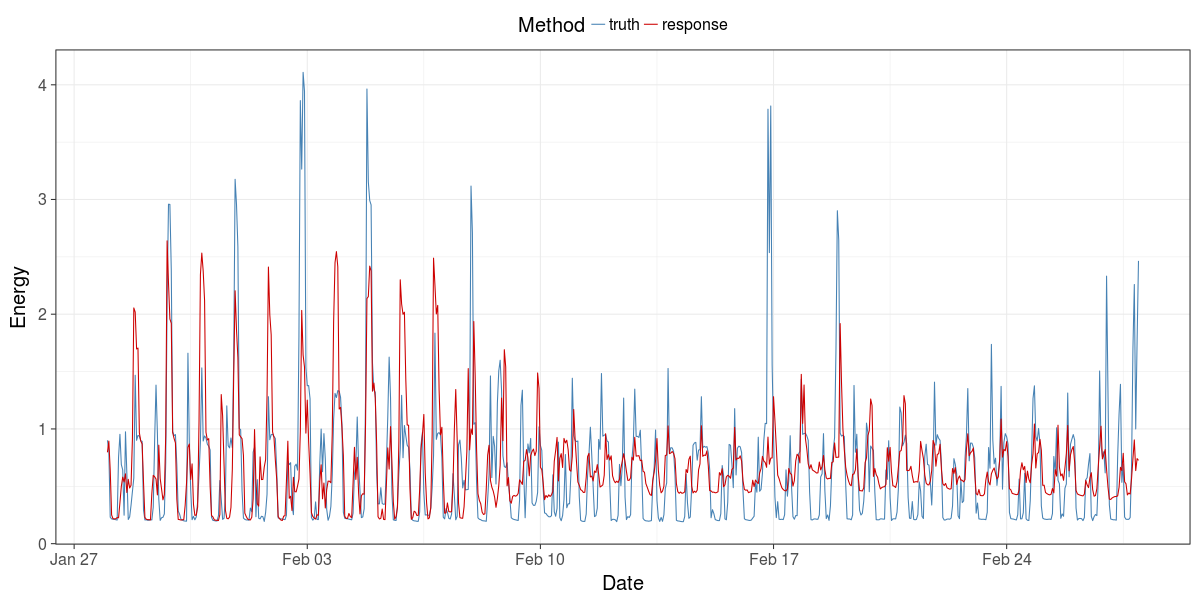

In [84]:
%%R -w 1200 -h 600
predictions <- auto.arima.resample$pred$data
predictionsLong <- add_time(df, predictions)
plot_predictions(predictionsLong)

We get an improvement of about **33%** (MAPE), but on the price of higher computational costs. Let us check if **growing window** brings some improvements.

In [85]:
%%R
resamp.desc <- makeResampleDesc("GrowingCV", horizon = nOut, initial.window = initWindow, skip = nOut)
auto.arima.resample <- resample(learner    = auto.arima.model, 
                                task       = fcregr.task, 
                                resampling = resamp.desc, 
                                measures   = list(mape, rmse))

In [86]:
%%R
auto.arima.resample

Resample Result
Task: smart_meter_london
Learner: fcregr.auto.arima
Aggr perf: mape.test.mean=0.6067832,rmse.test.rmse=0.4912397
Runtime: 196.148


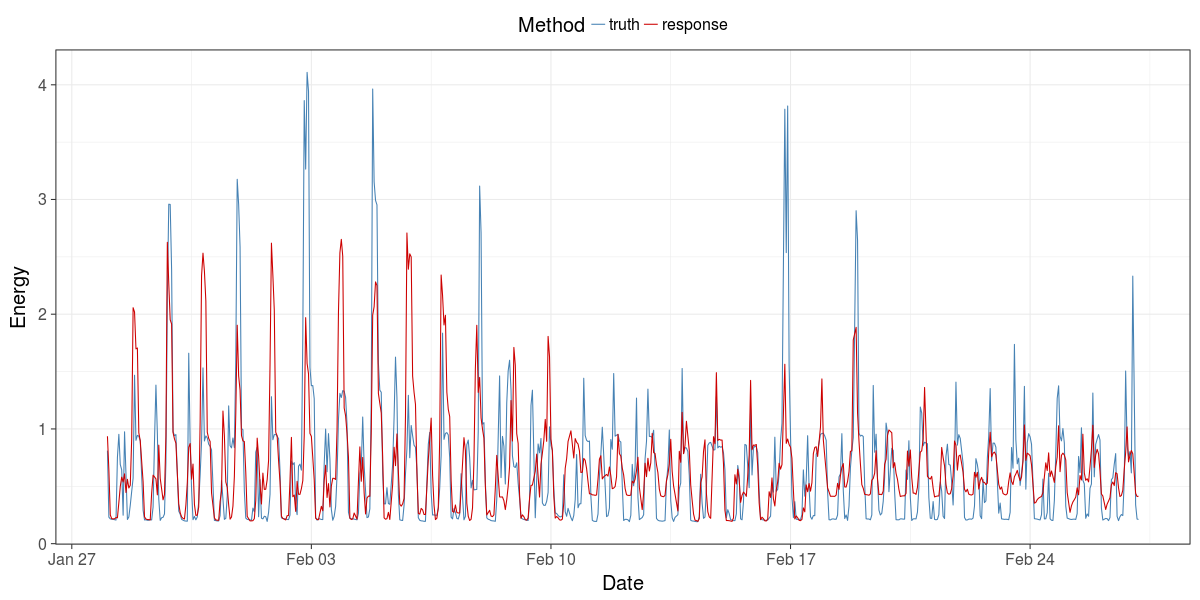

In [87]:
%%R -w 1200 -h 600
predictions <- auto.arima.resample$pred$data
predictionsLong <- add_time(df, predictions)
plot_predictions(predictionsLong)

Applying **Growing Window** for rolling forecast brings us another **7%** MAPE improvement. 

### Exponential Smoothing State Space Model

In [88]:
%%R
resamp.desc <- makeResampleDesc("FixedCV", horizon = nOut, initial.window = initWindow, skip = nOut)
ets.resample <- resample(learner    = ets.model, 
                         task       = fcregr.task, 
                         resampling = resamp.desc, 
                         measures   = list(mape, rmse))

In [89]:
%%R
ets.resample

Resample Result
Task: smart_meter_london
Learner: fcregr.ets
Aggr perf: mape.test.mean=0.7482027,rmse.test.rmse=0.7603732
Runtime: 115.856


In [90]:
%%R
resamp.desc <- makeResampleDesc("GrowingCV", horizon = nOut, initial.window = initWindow, skip = nOut)
ets.resample <- resample(learner    = ets.model, 
                         task       = fcregr.task, 
                         resampling = resamp.desc, 
                         measures   = list(mape, rmse))

In [91]:
%%R
ets.resample

Resample Result
Task: smart_meter_london
Learner: fcregr.ets
Aggr perf: mape.test.mean=0.5674899,rmse.test.rmse=0.5057613
Runtime: 133.612


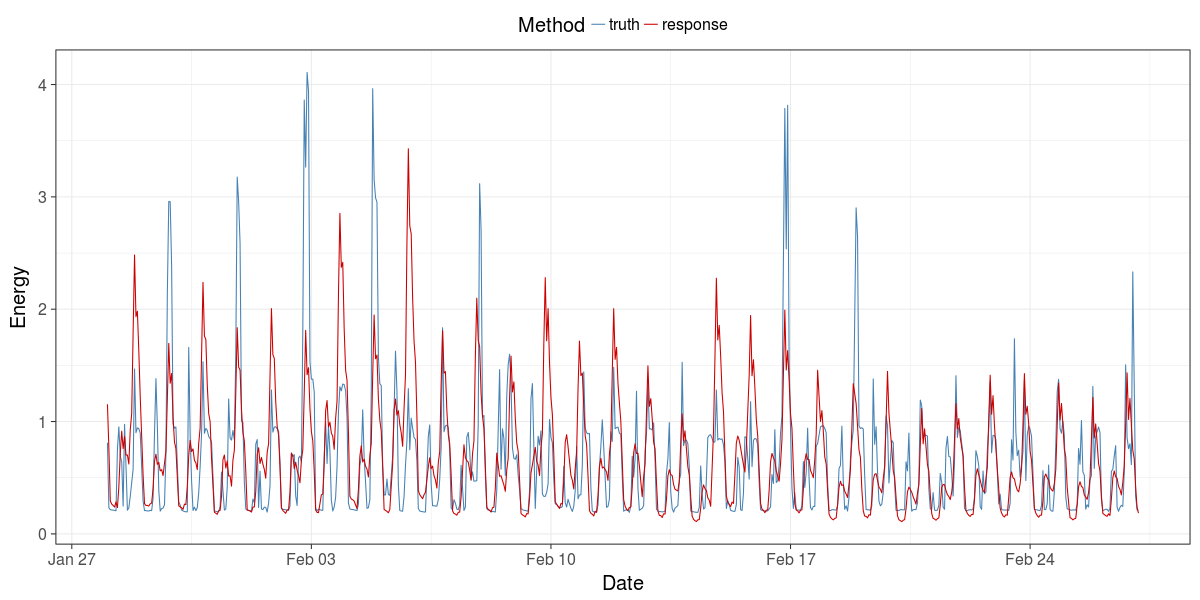

In [92]:
%%R -w 1200 -h 600
predictions <- ets.resample$pred$data
predictionsLong <- add_time(df, predictions)
plot_predictions(predictionsLong)

### GARCH




In [54]:
%%R
garch.mod <- makeLearner("fcregr.garch",
                         model = "sGARCH", garchOrder = c(2,1),
                         n.ahead = 24L, include.mean = FALSE)

In [58]:
%%R
resamp.desc <- makeResampleDesc("GrowingCV", horizon = nOut, initial.window = initWindow, skip = nOut)
garch.resample <- resample(learner    = garch.mod, 
                           task       = fcregr.task, 
                           resampling = resamp.desc, 
                           measures   = list(mape, rmse))

In [59]:
%%R
garch.resample

Resample Result
Task: smart_meter_london
Learner: fcregr.garch
Aggr perf: mape.test.mean=0.7683924,rmse.test.rmse=0.7804230
Runtime: 8.22822


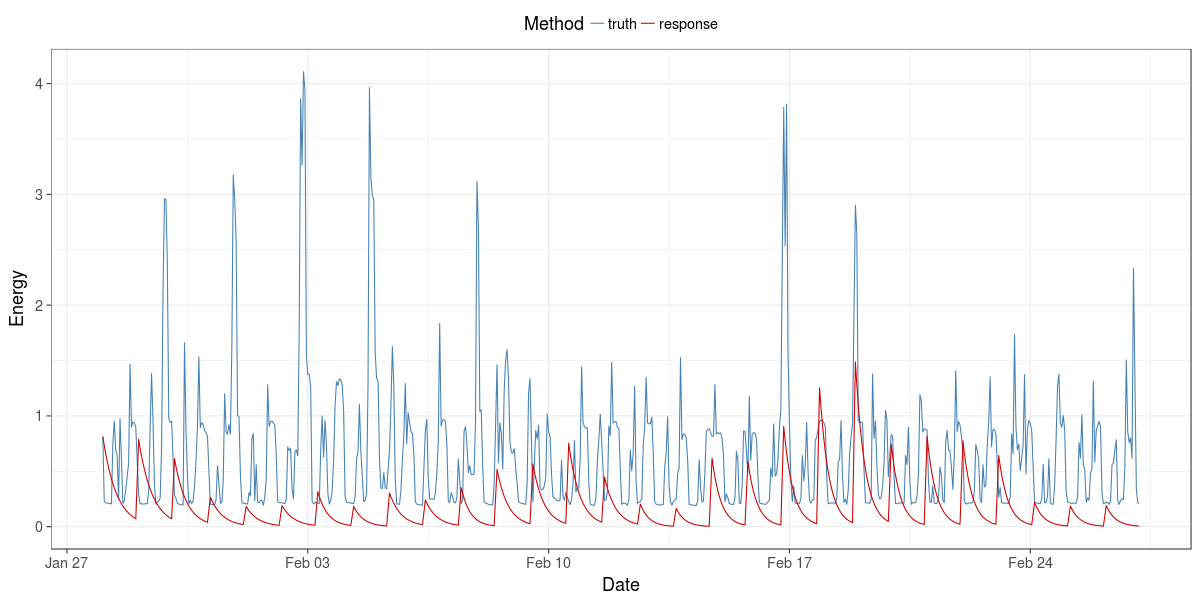

In [60]:
%%R -w 1200 -h 600
predictions <- garch.resample$pred$data
predictionsLong <- add_time(df, predictions)
plot_predictions(predictionsLong)

A really bad prediction. Let us perform a parameter optimization.

# Hyperparameter Optimization: GARCH Model

**Attention**: This is a compute intensive operation.

Detailed description of the applied GARCH model can be found on the developers web page [http://www.unstarched.net/](http://www.unstarched.net/) or on [CRAN](https://cran.r-project.org/web/packages/rugarch/index.html).

The following code shows how to perform a hyper-parameter selection for a time series model in R. The GARCH model is chosen in this example.

In [62]:
%%R
library(mlrMBO)

# Define the parameter set
par_set <- makeParamSet(
  makeDiscreteParam(id = "model", values = c("sGARCH", "fGARCH")),
  makeDiscreteParam(id = "submodel", values = c("GARCH", "NGARCH"),
                    requires = quote(model == "fGARCH")),
  makeIntegerVectorParam(id = "garchOrder", len = 2L, lower = 1, upper = 10))

# Specify tune by Irace: increase maxExperiments
ctrl <- makeTuneControlIrace(maxExperiments = 150L)

# GARCH Model
garch.mod <- makeLearner("fcregr.garch",
                        model = "sGARCH", garchOrder = c(2,1),
                        n.ahead = 24L, include.mean = FALSE)

# Parallel parameter search
library(parallelMap)
parallelStartSocket(6)
configureMlr(on.learner.error = "warn")
res <- tuneParams(garch.mod, task = fcregr.task,
                  resampling = resamp.desc, par.set = par_set,
                  control = ctrl, measures = mape)
parallelStop()

# Finally, set "best" parameters
garch.mod <- setHyperPars2(garch.mod, par.vals = res$x)

In [63]:
%%R
garch.mod

Learner fcregr.garch from package rugarch
Type: fcregr
Name: Generalized AutoRegressive Conditional Heteroskedasticity; Short name: garch
Class: fcregr.garch
Properties: numerics,quantile
Predict-Type: response
Hyperparameters: model=sGARCH,garchOrder=10,10,n.ahead=24,include.mean=FALSE



In [64]:
%%R
garch.resample <- resample(learner    = garch.mod, 
                           task       = fcregr.task, 
                           resampling = resamp.desc, 
                           measures   = list(mape, rmse))

In [65]:
%%R
garch.resample

Resample Result
Task: smart_meter_london
Learner: fcregr.garch
Aggr perf: mape.test.mean=0.7474849,rmse.test.rmse=0.7707713
Runtime: 46.0105


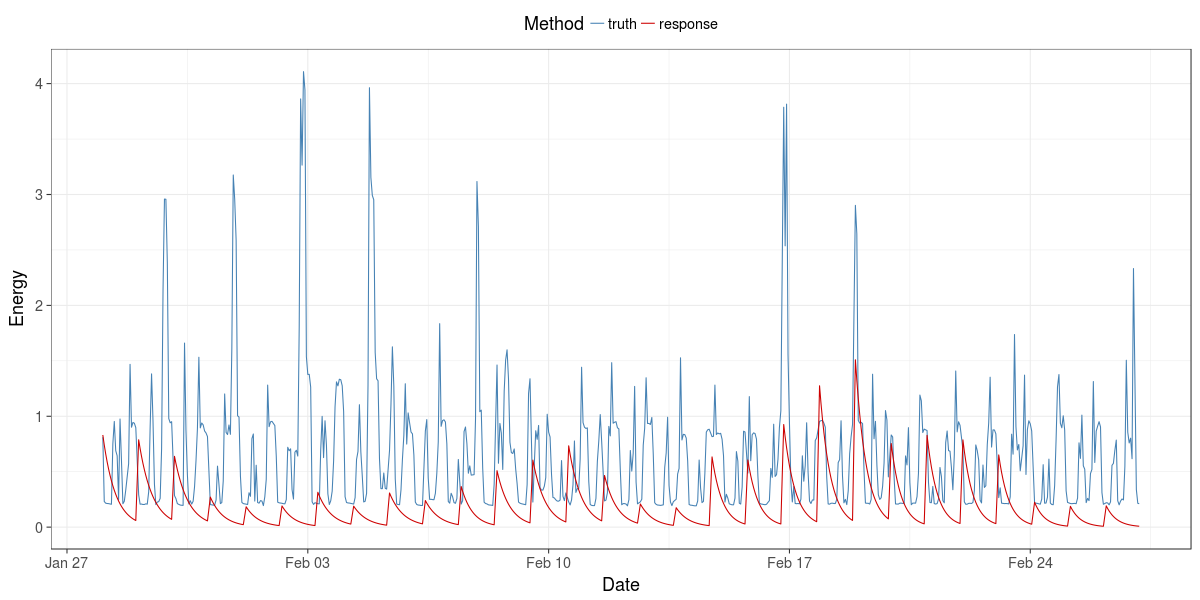

In [66]:
%%R -w 1200 -h 600
predictions <- garch.resample$pred$data
predictionsLong <- add_time(df, predictions)
plot_predictions(predictionsLong)

No improvemnet

## Final Comment

Thanks to Steve Bronder for including time series models to the mlr package

There are many more ways to go from here, e.g.

- try more models,
- multivariate models,
- transformation of the response variable,
- ...